# Training Models

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import gcsfs
fs = gcsfs.GCSFileSystem()
import os
import sys
import cftime
import time
from dask.diagnostics import ProgressBar

## Load Data 

In [2]:
from utils import load_vars_xarray, split_input_output

In [3]:
def list_all_vars():
    mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
    ds = xr.open_dataset(mapper, engine='zarr')
    all_input_vars = list(ds.data_vars)[:-2]
    
    mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
    ds = xr.open_dataset(mapper, engine='zarr')
    all_output_vars = list(ds.data_vars)[:-2]
    return(all_input_vars, all_output_vars)

i, o = list_all_vars()
print(o)

['cam_out_FLWDS', 'cam_out_NETSW', 'cam_out_PRECC', 'cam_out_PRECSC', 'cam_out_SOLL', 'cam_out_SOLLD', 'cam_out_SOLS', 'cam_out_SOLSD', 'state_q0001', 'state_q0002', 'state_q0003', 'state_t', 'state_u', 'state_v']


In [4]:
# same variables as VED paper
# humidity, temp, solar insolation, latent and sensible heat, surface pressure
input_vars = 'state_q0001 state_t pbuf_SOLIN pbuf_LHFLX pbuf_SHFLX state_ps'.split()
output_vars = ['state_q0001', 'state_t', 'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECC']


In [5]:
ds = load_vars_xarray(input_vars, output_vars, downsample=True, chunks = True)
ds

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/dataset.py:255: UserWarning: The specified Dask chunks separate the stored chunks along dimension "sample" starting at index 720. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Daily average


<xarray.Dataset>
Dimensions:            (time: 2920, lev: 60, ncol: 384)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 ... 378 379 380 381 382 383
    lat                (ncol) float64 -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
    lon                (ncol) float64 -39.73 -28.47 -39.56 ... 123.3 146.7 135.0
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    state_t            (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    pbuf_SOLIN         (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    pbuf_LHFLX         (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    pbuf_SHFLX         (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    state_ps           (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    out_state_q0001    (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    out_state_t        (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    out_cam_out_NETSW  (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    out_cam_out_FLWDS  (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    out_cam_out_PRECC  (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [6]:
def select_region(ds, condition):
    # assumes condition is a lambda function taking in a lat and lon
    # returns the indices for which this is true
    lat, lon = ds.lat.values, ds.lon.values
    latlon = pd.DataFrame({"lat" : lat, "lon": lon})
    return(list(latlon[latlon.apply(condition, axis=1)].index)) # the indices of the matching latlons

def split_ds_by_area(ds, condition):
    match = select_region(ds, condition)
    unmatch = select_region(ds, lambda row : not condition(row))
    return(ds.isel(ncol=match), ds.isel(ncol=unmatch))

### Process and Load Dataset

In [11]:
selected_levels = np.append(np.linspace(4, 24, 6), np.linspace(26, 59, 14)).astype(np.int32)
ds = ds.isel(lev=selected_levels)
selected_levels

array([ 4,  8, 12, 16, 20, 24, 26, 28, 31, 33, 36, 38, 41, 43, 46, 48, 51,
       53, 56, 59], dtype=int32)

In [15]:
ds = ds.isel(time = slice(0, 3*365), ncol=slice(0, 16))

In [16]:
ds.time.size * ds.ncol.size

17520

In [17]:
with ProgressBar():
    ds.load()

[########################################] | 100% Completed | 511.20 s


In [18]:
train = ds.isel(ncol=select_region(ds, lambda row : abs(row.lat) < 30))
test = ds.isel(ncol=select_region(ds, lambda row : 30 < abs(row.lat) < 60))

## Dataloader

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu" 

In [21]:
def normalize(xarr):
    var_means = xarr.mean(dim=['time', 'ncol']) # spatiotemporal mean
    var_stds = xarr.std(dim=['time', 'ncol']) # spatiotemporal meana
    arr = (xarr - var_means) / var_stds
    
    means = []
    stds = []
    for var in arr.data_vars:
        means.append(var_means[var].values.reshape(-1, 1))
        stds.append(var_stds[var].values.reshape(-1, 1))
    return(arr, np.vstack(means)[:, 0], np.vstack(stds)[:,0])

In [10]:
#X_norm, mean, std = normalize(X)

In [22]:
class MyDataset(Dataset):
    def __init__(self, ds, device = "cuda" if torch.cuda.is_available() else "cpu"):
        self.ds = ds
        self.X_ds, self.Y_ds = split_input_output(ds)
        self.device = device
        
        self.X_norm, self.X_mean, self.X_std = normalize(self.X_ds)
        self.Y_norm, self.Y_mean, self.Y_std = normalize(self.Y_ds)
        
    def __len__(self):
        return( self.ds.time.size * self.ds.ncol.size )
    
    def __getitem__(self, idx):
        t, col = idx // self.ds.ncol.size, idx % self.ds.ncol.size
        X = self.X_norm.isel(time=t, ncol=[col])
        Y = self.Y_norm.isel(time=t, ncol=[col])
        
        X = X.to_stacked_array("v", sample_dims=["ncol"]).values
        Y = Y.to_stacked_array("v", sample_dims=["ncol"]).values
        
        X = torch.as_tensor(X, device=self.device, dtype=torch.float32)
        Y = torch.as_tensor(Y, device=self.device, dtype=torch.float32)
        return(X.flatten(), Y.flatten())

In [23]:
%%time
dataset = MyDataset(ds, device)
x, y = dataset[0]

CPU times: user 996 ms, sys: 232 ms, total: 1.23 s
Wall time: 1.23 s


In [31]:
# can reconstruct via stored means
X_rec = dataset.X_mean + dataset.X_norm.numpy() * dataset.X_std
print(X_rec[-4:])
dataset.X_ds.isel(time=0, ncol=5)

In [33]:
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 512]
times = []
for size in batch_sizes:
    start = time.time()
    dl = DataLoader(dataset, batch_size=size, shuffle=True)
    x, y = next(iter(dl))
    times.append(time.time() - start) 
    print(f"{x.shape}, {y.shape}, took {time.time() - start} seconds \n")

torch.Size([1, 44]), torch.Size([1, 43]), took 0.05240154266357422 seconds 

torch.Size([2, 44]), torch.Size([2, 43]), took 0.0874016284942627 seconds 

torch.Size([4, 44]), torch.Size([4, 43]), took 0.17470192909240723 seconds 

torch.Size([8, 44]), torch.Size([8, 43]), took 0.3521735668182373 seconds 

torch.Size([16, 44]), torch.Size([16, 43]), took 0.6709597110748291 seconds 

torch.Size([32, 44]), torch.Size([32, 43]), took 1.3588073253631592 seconds 

torch.Size([64, 44]), torch.Size([64, 43]), took 2.727426528930664 seconds 

torch.Size([128, 44]), torch.Size([128, 43]), took 5.3670127391815186 seconds 

torch.Size([512, 44]), torch.Size([512, 43]), took 21.648482084274292 seconds 



In [40]:
times_toy_ds = [0.017, 0.02973, 0.0584, 0.12579, 0.2341, 0.4631, 0.899, 1.795, 7.21] # copied from DataProcessing
# Loading a sample takes almost 3x longer than toy dataset

In [85]:
i = 5
print(f"with batch size of {batch_sizes[i]}, ought to take {times[i]} x  {len(dataset) / batch_sizes[i]} = {times[i] * len(dataset) / batch_sizes[i]} seconds per epoch")

with batch size of 32, ought to take 1.3587939739227295 x  547.5 = 743.9397007226944 seconds per epoch


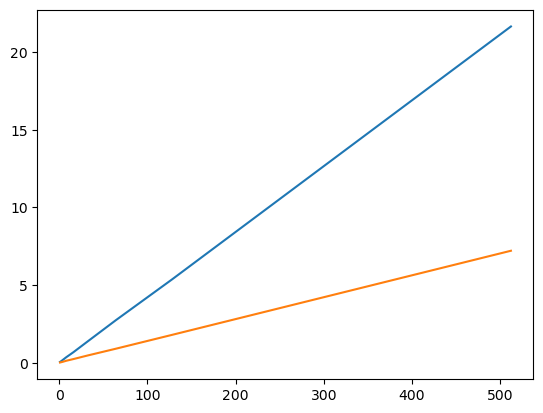

In [46]:
plt.plot(batch_sizes, times)
plt.plot(batch_sizes, times_toy_ds)

### Exploratory Data Analysis

In [29]:
#ds['lon'] = (ds.lon + 180) % 360 - 180
select_region(ds, lambda row : (abs(row.lon - -73) < 5 and abs(row.lat-40) < 2)) # selecting specific latlon
ny_col = select_region(ds, lambda row : (abs(row.lon - -73) < 5 and abs(row.lat-40) < 2))
ny_col # new york

[251]

In [ ]:
ds.where(ds.isnull()).sum() # no Nan Values

In [ ]:
plt.plot(ds.state_q0001.isel(time=20, ncol=15), label='full')
plt.plot(selected_levels, toy.state_q0001.isel(time=20, ncol=15), label='reduced_levels')
plt.legend()
plt.show()

In [ ]:
X, Y = split_input_output(train)
plt.plot(((X - X.mean(dim=['time', 'ncol'])) / X.std(dim)))

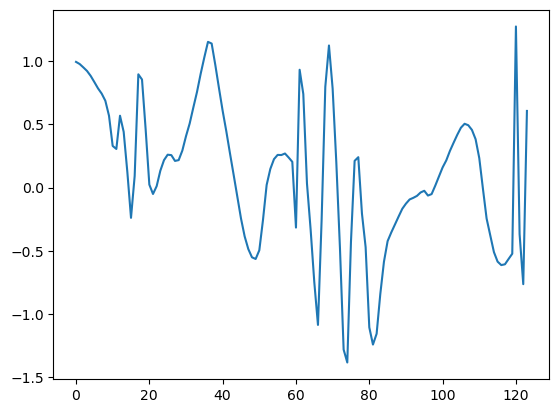

In [42]:
plt.plot(X_sample[1, :].cpu())

In [30]:
%%time
i = 10
X_norm, Y_norm = dataset[i]
print(X_norm.shape, Y_norm.shape, '\n')
plt.plot(Y_norm.cpu().numpy())
plt.show()

NameError: name 'dataset' is not defined

## Define Model

In [47]:
class VariationalEncoder(torch.nn.Module):
    """
    Conditional VAE Encoder with <layers>+1 fully connected layer
    """
    def __init__(self, in_dims, hidden_dims=[128, 128, 64, 32], latent_dims=5, layers=4, dropout=0, device='cuda'):
        super().__init__()
        self.linears = [torch.nn.Sequential(
                torch.nn.Linear(in_dims, hidden_dims[0]),
                torch.nn.LayerNorm(hidden_dims[0]),
                torch.nn.Dropout(p=dropout))]
        self.add_module('linear0', self.linears[-1])
        for i in range(1, layers):
            self.linears += [torch.nn.Sequential(
                torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]),
                torch.nn.LayerNorm(hidden_dims[i]),
                torch.nn.Dropout(p=dropout))
                ]
            self.add_module('linear%d' % i, self.linears[-1])
        self.linear_mean = torch.nn.Linear(hidden_dims[-1], latent_dims)
        self.linear_logstd = torch.nn.Linear(hidden_dims[-1], latent_dims) # log of actual, later exponentiate

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
        
        self.device = device
        
    def forward(self, x, return_latent=False):
        if(len(x.shape) > 1):
            x = torch.flatten(x, start_dim=1)
        for linear in self.linears:
            x = torch.nn.functional.relu(linear(x))
        mu = self.linear_mean(x) # mu is g(l(x))
        if return_latent:
            return mu
        else:
            sigma = torch.exp(self.linear_logstd(x)) # sigma is h(l(x))
            z = mu + sigma * self.N.sample(mu.shape) # reparameterization trick
            self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).mean()
            return z



In [48]:
class Decoder(torch.nn.Module):
    """
    Conditional VAE Decoder with <layers>+1 fully connected layer
    """
    def __init__(self, out_dims, hidden_dims=[32, 64, 128, 128], latent_dims=3, layers=4, dropout=0):
        super().__init__()
        self.linears = [torch.nn.Sequential(
                torch.nn.Linear(latent_dims, hidden_dims[0]),
                torch.nn.LayerNorm(hidden_dims[0]),
                torch.nn.Dropout(p=dropout))]
        self.add_module('linear0', self.linears[-1])
        
        for i in range(1, layers):
            self.linears += [torch.nn.Sequential(
                torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]),
                torch.nn.LayerNorm(hidden_dims[i]),
                torch.nn.Dropout(p=dropout))
                ]
            self.add_module('linear%d' % i, self.linears[-1])        

        self.final_linear1 = torch.nn.Linear(hidden_dims[-1], out_dims)
        # self.final_linear2 = torch.nn.Linear(hidden_dims, out_dims)
        self.final_log_std1 = torch.nn.Linear(hidden_dims[-1], out_dims)
        # self.final_log_std2 = torch.nn.Linear(hidden_dims, out_dims)
        # self.final_lambda = torch.nn.Linear(hidden_dims, 1)
        # self.final_prob_zero = torch.nn.Linear(hidden_dims, out_dims)

    def forward(self, z): # outputs distribution
        for linear in self.linears:
            z = torch.nn.functional.relu(linear(z))
        m1 = self.final_linear1(z)
        # m2 = self.final_linear2(z)
        s1 = torch.exp(self.final_log_std1(z))
        # s2 = torch.exp(self.final_std2(z))
        # lam = self.final_lambda
        # p0 = torch.sigmoid(self.final_prob_zero(z))
        return m1, s1

In [49]:
class VariationalEncoderDecoder(torch.nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.data_dims = model_params['data_dims']
        self.label_dims = model_params['label_dims']
        self.latent_dims = model_params['latent_dims']
        self.device = model_params['device']
        dropout = model_params['dropout']

        # Encoder - compresses data into latent dims
        self.encoder = VariationalEncoder(self.data_dims, model_params['input_layers'], self.latent_dims, 
                       len(model_params['input_layers']), dropout).to(self.device)

        # Decoder - tries to learn both input and output variables. 
        self.decoder = Decoder(self.label_dims + self.data_dims, model_params['output_layers'], self.latent_dims, 
                               layers=len(model_params['output_layers']), dropout=dropout).to(self.device)
        self.beta = model_params['beta']
        
        self.losses = []

    def forward(self, x, return_latent=False):
        # expect to be batch_size x data_dims matrix and y to be batch_size x label_dims matrix
        
        z = self.encoder(x, return_latent)
        if return_latent:
            return z
        O_hat_mu, O_hat_std = self.decoder(z)
        return O_hat_mu, O_hat_std

In [ ]:
E2 = VariationalEncoder(model_params['data_dims'], model_params['input_layers'], 
       model_params['latent_dims'], len(model_params['input_layers']), dropout=model_params['dropout']).to(device)
E2

VariationalEncoder(
  (linear0): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.05, inplace=False)
  )
  (linear_mean): Linear(in_features=32, out_features=6, bias=True)
  (linear_logstd): Linear(in_features=32, out_features=6, bias=True)
)

In [ ]:
E2(x)

tensor([ 1.3945, -0.8874, -0.1882, -1.3328,  0.6627,  0.5081], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
%%time
E2 = VariationalEncoder(model_params['data_dims'], model_params['input_layers'], 
       model_params['latent_dims'], len(model_params['input_layers']), dropout=model_params['dropout']).to(device)

optim = torch.optim.SGD(E2.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])

num_iters = 100
kls = []
batch_times = []
optim_times = []
start = time.time()
for i in range(num_iters):
    x, y = toy_dataset[i]
    batch_time = time.time()
    batch_times.append(batch_time - start)
    z = E2(x)
    kls.append(E2.kl.item())
    E2.kl.backward()
    optim.step()
    optim.zero_grad()
    optim_times.append(time.time() - batch_time)
    start = time.time()

CPU times: user 1.47 s, sys: 12 ms, total: 1.48 s
Wall time: 1.48 s


In [ ]:
sum(batch_times)

1.3269221782684326

In [ ]:
sum(optim_times)

0.15437006950378418

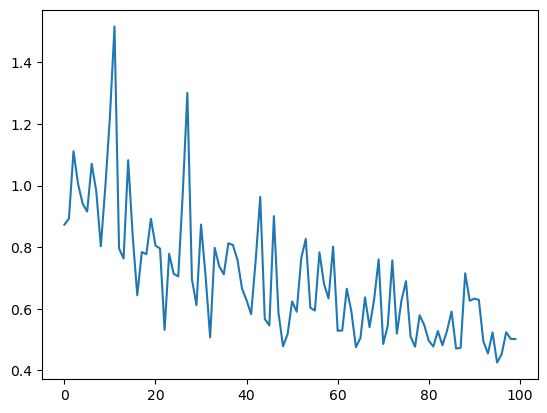

In [ ]:
plt.plot(kls) # more spontaneous, but expected since SGD?

### Reproduced Bug! NaN results

Training [100.0 %] - 70 / 70 (12 / 12) - 4.3s [TBD: 0.0s]
Last-epoch loss: nan
Finished Training


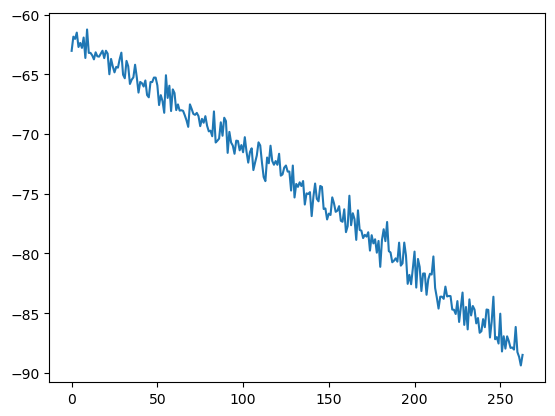

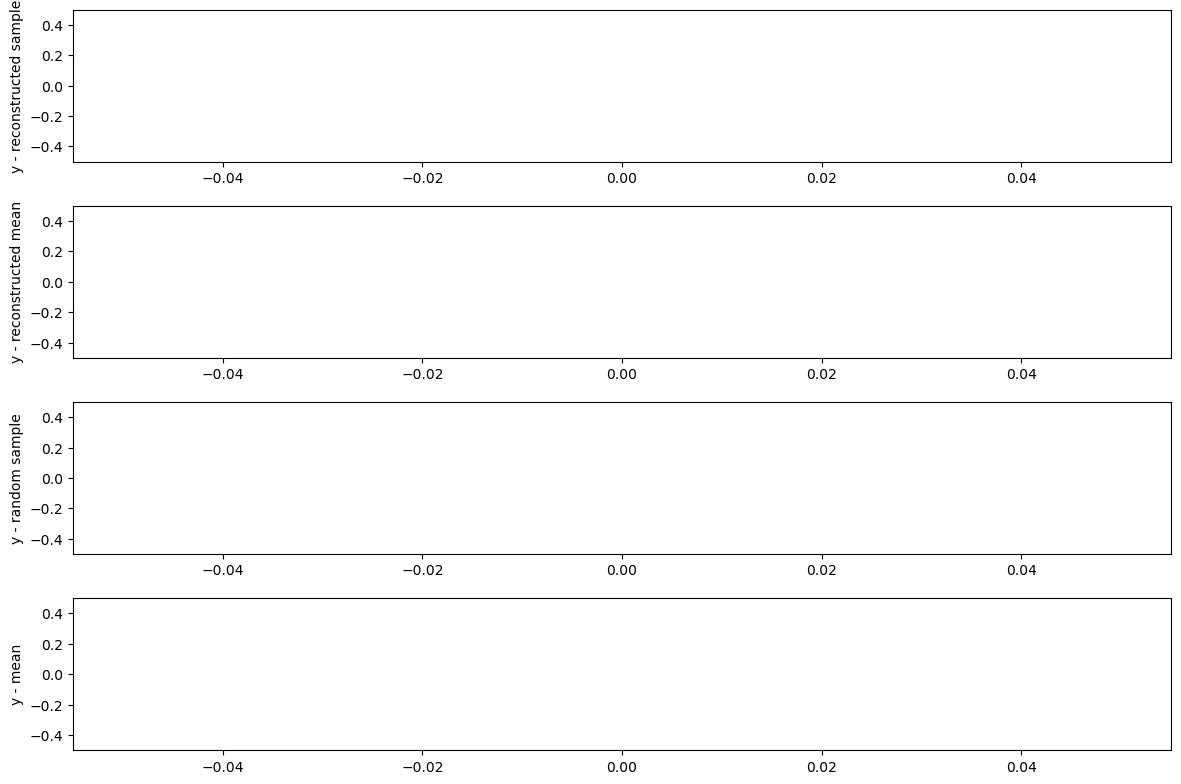

In [446]:
losses = model.trainer(fake_dataloader, save_params, train_params)

In [447]:
model(x, y)

(tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        device='cuda:0', grad_fn=<ExpBackward0>))

# Train and Evaluate Models

## Toy Baseline Model

In [65]:
device= 'cuda'

In [68]:
class ToyModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, output_size, bias=True)
    
    def forward(self, x):
        return(self.linear(x))
    
    def trainer(self, num_epochs, dataloader, lr=0.001):
        self.train()
        optim = torch.optim.SGD(self.parameters(), lr=lr)
        losses = []
        for epoch in range(num_epochs):
            batch_times = []
            backprop_times = []
            start = time.time()
            for batch, (X, y) in enumerate(dataloader):
                batch_time = time.time()
                batch_times.append(batch_time - start)
                pred = self(X)
                loss = (pred - y)**2
                loss.sum().backward()
                optim.step()
                optim.zero_grad()
                backprop_times.append(time.time() - batch_time)
                losses.append(loss.mean().item())
                start = time.time()
            print(f"Epoch : {epoch}; avg batching={np.mean(batch_times)}; avg backprop={np.mean(backprop_times)}")   
                
        return(losses)

In [69]:
x, y = toy_dataset[0]
x.shape[0]

40

In [70]:
toy_model = ToyModel(x.shape[-1], y.shape[-1]).to('cuda')
toy_model

ToyModel(
  (linear): Linear(in_features=40, out_features=1, bias=True)
)

In [71]:
%%time
num_epochs = 3
losses = toy_model.trainer(num_epochs, toy_dataloader)

Epoch : 0; avg batching=0.4290027201501398; avg backprop=0.00088462933816545
Epoch : 1; avg batching=0.425509659970393; avg backprop=0.0008596058100299106
Epoch : 2; avg batching=0.43084282041247424; avg backprop=0.0008982387396807228
CPU times: user 3min 54s, sys: 1.31 s, total: 3min 55s
Wall time: 3min 55s


[2.386765241622925,
 1.8761513233184814,
 0.8051239252090454,
 0.41617944836616516,
 0.6716220378875732,
 0.8658982515335083,
 0.6051923036575317,
 1.2757468223571777,
 0.2988331913948059,
 0.36122995615005493,
 0.3121259808540344,
 1.1467030048370361,
 0.9178881645202637,
 0.4954041540622711,
 0.2358592003583908,
 0.40547919273376465,
 0.278512179851532,
 0.45687851309776306,
 0.4017557203769684,
 0.4028594493865967,
 0.3644106984138489,
 0.6063108444213867,
 0.6837299466133118,
 1.4608982801437378,
 0.7247801423072815,
 0.4431780278682709,
 0.22989657521247864,
 1.0222480297088623,
 1.584335207939148,
 0.7772551774978638,
 1.3758747577667236,
 1.6957783699035645,
 0.9273055791854858,
 2.071084976196289,
 1.6002326011657715,
 1.5584895610809326,
 1.6363437175750732,
 0.5316412448883057,
 0.2802412509918213,
 2.3738200664520264,
 2.2056779861450195,
 1.5232465267181396,
 1.8080880641937256,
 1.4014312028884888,
 0.3552132844924927,
 0.2967804968357086,
 0.26800602674484253,
 0.14889506

In [108]:
len(toy_dataloader) * 0.44 * num_epochs / 60 # explanation of time

13.383333333333333

In [72]:
# Save Toy Model
baseDir = '/home/jovyan/Samarth/Main/saved_data/'
toy_model_path = os.path.join(baseDir, 'models/toy_model1.pt')

torch.save(toy_model.state_dict(), toy_model_path)

## Actual Model

In [78]:
#from Architectures.VED import VariationalEncoderDecoder

In [54]:
x, y = dataset[0]
len(y)

43

In [63]:
model_params = {'beta': 0.05,
    'data_dims': len(x),
    'label_dims': len(y),
    'latent_dims': 6,
    'input_layers': [32, 16],
    'output_layers': [16, 32],
    'dropout': 0.05,
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'architecture': 'ved'}
                

In [64]:
VED = VariationalEncoderDecoder(model_params)
VED

VariationalEncoderDecoder(
  (encoder): VariationalEncoder(
    (linear0): Sequential(
      (0): Linear(in_features=44, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear_mean): Linear(in_features=16, out_features=6, bias=True)
    (linear_logstd): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Decoder(
    (linear0): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(

In [81]:
len(dataset)

17520

In [82]:
def get_num_parameters(model, show=False):
    p = iter(model.parameters())
    num = 0
    for param in p:
        ps = 1
        for i in param.shape:
            ps = ps * i
        if show:
            print(param.shape, ps)
        num = num + ps
    return(num)
get_num_parameters(VED, False)

8762

In [86]:
743.93 / 60

12.398833333333332

In [87]:
train_params = {'epochs': 10,
 'loss_type': 'mse',
 'optimizer': 'sgd',
 'lr': 0.01,
 'weight_decay': 0,
 'batch_size': 32}

In [88]:
dataloader = DataLoader(dataset, batch_size=train_params['batch_size'], shuffle=True)

In [90]:
save_params = {
    'name' : 'VED_real_trial', # RMB
    'plot' : True,
    'save' : True,
    'model_path' : "/home/jovyan/Samarth/Main/saved_data/models", 
    'savefig' : False,
    'save_interval' : 300,
    'figure_path' : '/home/jovyan/Samarth/Main/saved_data/figures',
    'filetype' : '.pt',
    
}

In [91]:
def trainer(model, dataloader, save_params, train_params):

    # Training parameters
    if train_params['optimizer'] == 'adam':
        opt = torch.optim.Adam(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    elif train_params['optimizer'] == 'sgd':
        opt = torch.optim.SGD(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    else:
        raise ValueError('Unknown optimizer')
    batches_per_epoch = len(dataloader)
    path = os.path.join(save_params['model_path'], save_params['name']) + save_params['filetype'] # checkpoint 
    text = 'Training '
    start = time.time()
    last = start
    last_timed = start

    losses = []
    KL_div = []
    for epoch in range(train_params['epochs']):
        for batch_num, (x,y) in enumerate(dataloader):
            now = time.time()
            if batch_num == 0 or batch_num == batches_per_epoch - 1 or now - last > 0.5: # print time status updates
                last = now
                perc = (epoch * batches_per_epoch + batch_num + 1) / (train_params['epochs'] * batches_per_epoch)
                inv_perc = (train_params['epochs'] * batches_per_epoch) / (epoch * batches_per_epoch + batch_num + 0.1)
                sys.stdout.write("\r%s[%.1f %%] - %d / %d (%d / %d) - %.1fs [TBD: %.1fs]" %
                                 (text, 100 * perc, epoch + 1, train_params['epochs'], batch_num + 1, batches_per_epoch,
                                  now - start, (now - start) * (inv_perc - 1)))
                sys.stdout.flush()
            if save_params['save'] and now - last_timed > save_params['save_interval']:
                torch.save(model.state_dict(), path)
                last_timed = now
            
            O_real = torch.cat([x, y], 1).to(model.device) # actual output desired 
            O_hat, O_std = model(x)

            # loss = ((y - y_hat) ** 2).sum() / self.label_dims + self.beta * self.encoder.kl / self.latent_dims
            rec_loss = 0.5 * (O_real - O_hat) ** 2 #+ torch.log(O_std)
            loss = rec_loss.mean() + model.beta * model.encoder.kl
            #loss = (0.5 * (y - y_mean) ** 2 / y_std + torch.log(y_std)).mean() + self.beta * self.encoder.kl

            #torch.clip(loss, min=-1e5, max=1e5).backward() # backpropagate loss
            KL_div.append(model.encoder.kl.item())
            losses.append(loss.item()) 
            loss.backward()
            opt.step()
            opt.zero_grad() # VERY IMPORTANT! Reset gradients. 

    print('Last-epoch loss: %.2f' % sum(losses[-batches_per_epoch:-1]))
    print('Finished Training')

    return(model, {"losses" : losses, "KL" : KL_div})

In [ ]:
model, info = trainer(VED, dataloader, save_params, train_params)

Training [98.6 %] - 10 / 10 (474 / 548) - 7343.1s [TBD: 101.8s]

In [114]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size

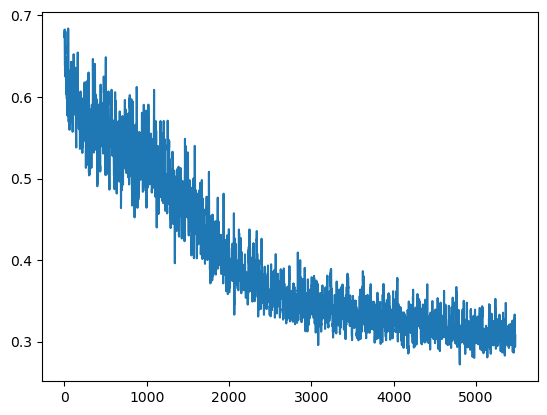

In [115]:
plt.plot(np.convolve(info['losses'], kernel, mode='valid'))

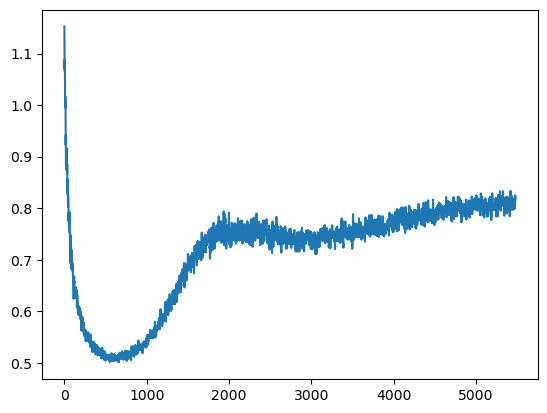

In [116]:
plt.plot(np.convolve(info['KL'], kernel, mode='valid'))

In [117]:
import json
def save_model(model):
    path = os.path.join(save_params['model_path'], save_params['name'])
    torch.save(model.state_dict(), path + save_params['filetype'])
    
    params = {
        'training_parameters' : train_params, 
        'model_parameters' : model_params, 
        'save_parameters' : save_params,
    }
    
    with open(path + ".json", 'w', encoding='utf-8') as f:
        json.dump(params, f, ensure_ascii=False, indent=4) 
    return(path)

In [118]:
save_model(model)

'/home/jovyan/Samarth/Main/saved_data/models/VED_real_trial'

In [551]:
from utils import load_model
m2 = load_model(model_params)
m2.load_state_dict(torch.load('/home/jovyan/Samarth/Main/saved_data/models/ved_toy1.pt'))

<All keys matched successfully>

# Evaluating results

In [ ]:
pwd

'/home/jovyan/Samarth/Pipelines'

In [119]:
baseDir = '/home/jovyan/Samarth/Main/saved_data/models'

In [126]:
model_params

{'beta': 0.05,
 'data_dims': 44,
 'label_dims': 43,
 'latent_dims': 6,
 'input_layers': [32, 16],
 'output_layers': [16, 32],
 'dropout': 0.05,
 'device': 'cuda',
 'architecture': 'ved'}

In [137]:
def load_model(name, baseDir = 'saved_data/models', load_params=True):
    path = os.path.join(baseDir, name)
    params = json.load(open(path + '.json'))
    model_params = params['model_parameters']
    architecture = model_params['architecture']
    match architecture.lower():
        case "ved":
            model = VariationalEncoderDecoder(model_params)
        case "vae":
            print("VAE loading not implemented")
        case "cvae":
            model = ConditionalVAE(model_params['beta'], model_params['data_dims'], model_params['label_dims'], dropout=model_params['dropout'],
                 latent_dims=model_params['latent_dims'], hidden_dims=model_params['hidden_dims'], layers=model_params['layers']).to(model_params['device'])
        case _:
            print("Unknown architecture")
    if(load_params): # load not just architecture but weights. Do unless training went terribly
        model.load_state_dict(torch.load(path + params['save_parameters']['filetype']))
    model.eval()

    return(model, params['training_parameters'])

In [138]:
model, train_params = load_model(save_params['name'], baseDir, True)

In [139]:
model

VariationalEncoderDecoder(
  (encoder): VariationalEncoder(
    (linear0): Sequential(
      (0): Linear(in_features=44, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear_mean): Linear(in_features=16, out_features=6, bias=True)
    (linear_logstd): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Decoder(
    (linear0): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(

In [140]:
import sklearn
from sklearn.decomposition import PCA
class LatentInterpreter():
    def __init__(self, encoder, dataset):
        self.model = encoder
        self.dataset = dataset
        self.embeddings = {}
        self.pca = 0

    def calculate_embeddings(self, num_samples=500, start_index=0):
        self.embeddings = {}
        with torch.no_grad():
            model.eval()
            for i in range(start_index, start_index + num_samples):
                x, y = self.dataset[i]
                z = self.model(x).to('cpu').numpy()
                self.embeddings[i] = z
    def embeddings_as_tensor(self):
        return(torch.tensor(np.vstack(list(self.embeddings.values())), dtype=torch.float32))
                
    def set_embeddings(self, embeddings):
        assert type(embeddings) == dict, "Expected a dictionary format"
        self.embeddings = embeddings
    
    def latentPCA(self):
        if(not len(self.embeddings)): # if have not saved embeddings
            self.get_embeddings()
        
        pca = PCA(n_components=2)
        pca.fit(list(self.embeddings.values()))
        self.pca = pca
    
    def plot_variable_PC(self, ds, variable, cmap='plasma', title='', savefig=False):
        # assume data to be segmented in some form to highlight/ visualize some specific trend
        # components is ndarray shape (n_components, n_features)
        if(not self.pca):
            self.latentPCA()
        
        if not title:
            title=f'{len(self.embeddings)} of {variable} visualized in latent space'
        pc1 = torch.tensor(self.pca.components_[0, :], dtype=torch.float32)
        pc2 = torch.tensor(self.pca.components_[1, :], dtype=torch.float32)
        
        z = self.embeddings_as_tensor()
        x_values = torch.matmul(z, pc1)
        y_values = torch.matmul(z, pc2)
        c_values = []
        
        for index in self.embeddings.keys():
            c_values.append(get_item_value(ds, index, variable).item())
        plt.scatter(x_values, y_values, c=c_values, cmap=cmap)
        plt.colorbar(label=variable)
        plt.xlabel("First Principal Component")
        plt.ylabel("Second Principal Component")
        plt.title(title)
        if(savefig):
            print("saving")
            plt.savefig('latent_space_ED')
        plt.show()
    
    def estimate_pz(self, dims, bins):
        z = self.embeddings_as_tensor()
        for dim in dims:
            plt.hist(z[:, dim], bins=bins, density=True)
            plt.title(f"Dimension {dim} of Latent Space")
            plt.xlabel("Value of z")
            plt.ylabel("Probability Density Estimate")
            plt.show()

In [141]:
%%time
interp = LatentInterpreter(model.encoder, dataset)
embeddings = interp.calculate_embeddings(500, start_index=1650)
interp.latentPCA()

CPU times: user 21.6 s, sys: 122 ms, total: 21.8 s
Wall time: 21.8 s


In [142]:
def get_item_value(ds, index, variable, level_value=19):
    # t * ds.ncol.size + col == i
    # given an index, wrap around (time x ncol) grid selecting specific variable
    # converting linear indexing into structured
    
    # if level variable can specify which level; default is surface but doesn't matter
    ds = ds.sel(lev=ds.lev[level_value])[variable]
    
    assert index < ds.time.size * ds.ncol.size, "Index is outside of range"
    t, col = index // ds.ncol.size, index % ds.ncol.size
    return(ds.isel(time=t, ncol=col))

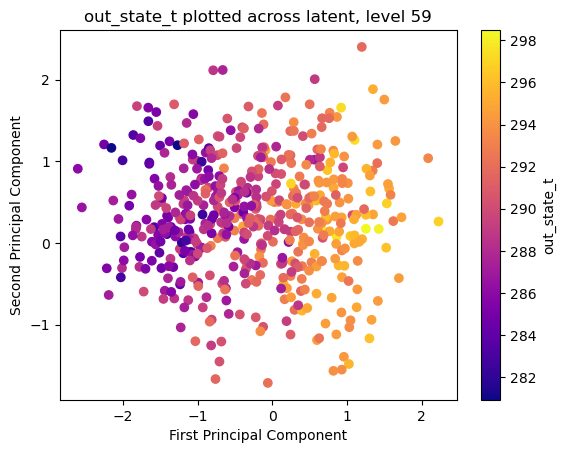

In [143]:
ds.data_vars
var = 'out_state_t'
interp.plot_variable_PC(ds, var, title=f'{var} plotted across latent, level {selected_levels[19]}', savefig=False)

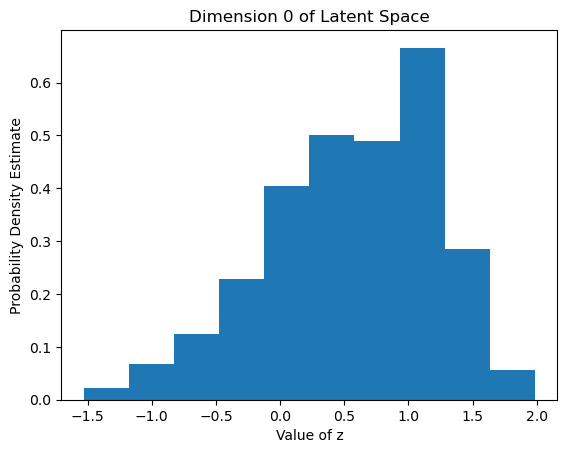

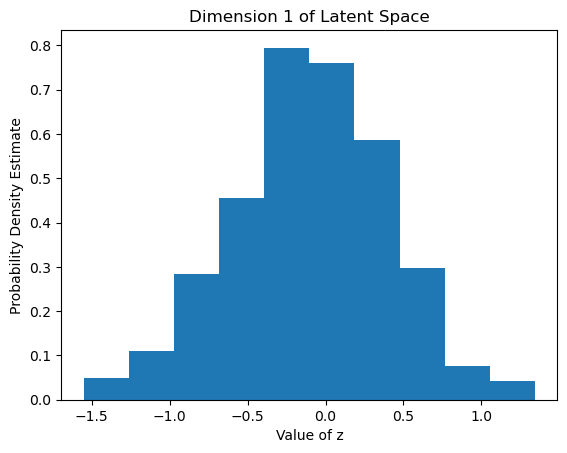

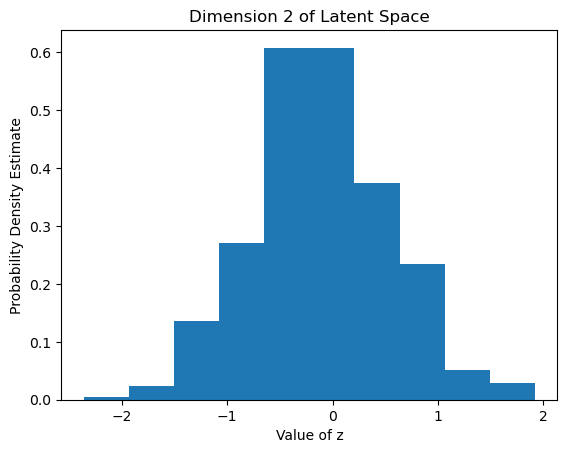

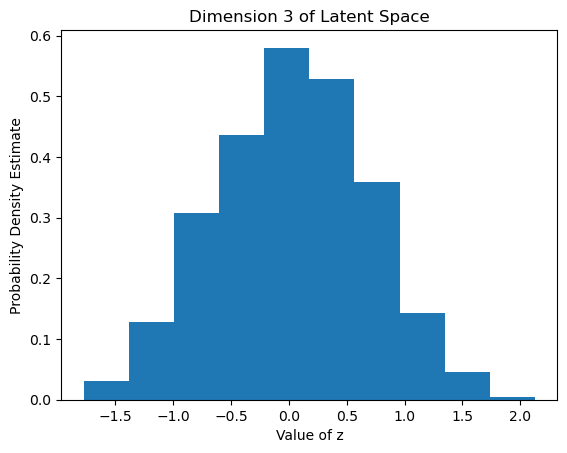

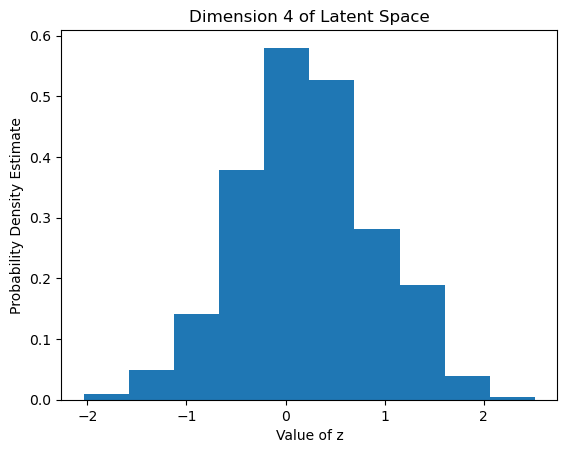

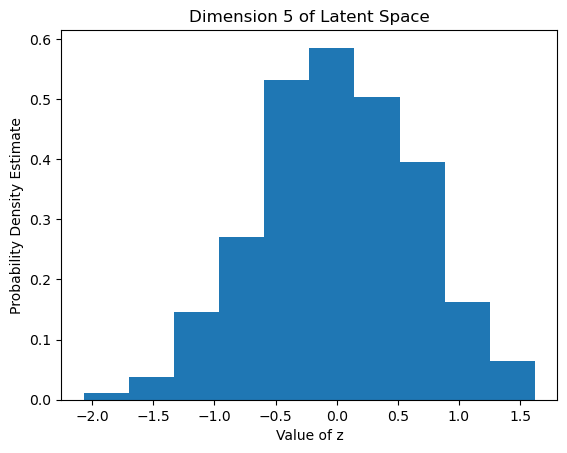

In [146]:
interp.estimate_pz([0, 1, 2, 3, 4, 5], 10)